<a href="https://colab.research.google.com/github/obisu/BN-Engineering/blob/master/explainAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install numpy
!pip install pandas
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install shapely

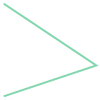

In [ ]:
from shapely.geometry import Point, LineString
# Create a LineString from coordinate sets
line = LineString([(0, 0), (3, 1), (0, 3)])
line

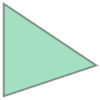

In [ ]:
from shapely.geometry import Polygon
polygon = Polygon([(0, 0), (3, 1), (0, 3)])
polygon

Explainable Clustering using CNN :

In [ ]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


Train the CNN

In [ ]:
# Download the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# Reshape and normalize data
x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

4422102/4422102 [==============================] - 0s 0us/step


For the CNN model you will use a simple architecture composed of a single convolutional and max pooling layers pair connected to a fully connected layer with 256 units and the output layer with 10 units since there are 10 categories.

In [ ]:
# Define the model architecture using the functional API
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)
# Create the model with the corresponding inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")
# Compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )
# Train it!
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))


Epoch 1/5
1875/1875 [==============================] - 63s 33ms/step - loss: 0.3762 - sparse_categorical_accuracy: 0.8676 - val_loss: 0.3314 - val_sparse_categorical_accuracy: 0.8800
Epoch 2/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2559 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.2767 - val_sparse_categorical_accuracy: 0.8985
Epoch 3/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.2065 - sparse_categorical_accuracy: 0.9253 - val_loss: 0.2490 - val_sparse_categorical_accuracy: 0.9101
Epoch 4/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.9364 - val_loss: 0.2488 - val_sparse_categorical_accuracy: 0.9118
Epoch 5/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1405 - sparse_categorical_accuracy: 0.9473 - val_loss: 0.2522 - val_sparse_categorical_accuracy: 0.9170


Explaining the outputs

You are aware that the model accurately classifies about 90% of the test set's photos. How, though, is it succeeding? What pixels are being used to categorise images into different classes?

You can use SHAP values to respond to these queries.

Check the appearance of each category before proceeding:

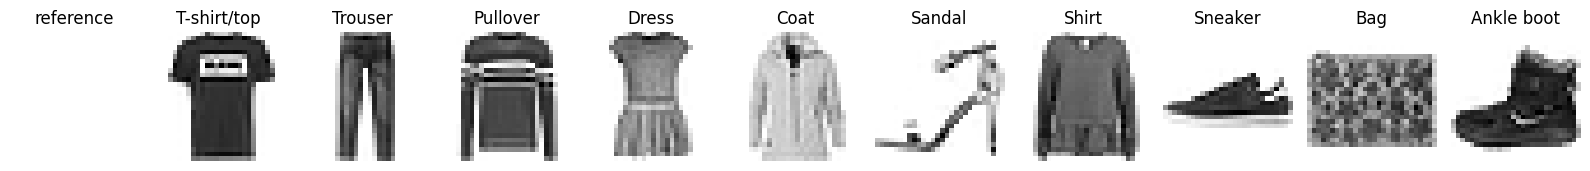

In [14]:
# Name each one of the classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[l] = x_train[i].reshape((28, 28))
# Function to plot images
def plot_categories(images):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()
  # Plot an empty canvas
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # Plot an image for every category
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{class_names[k]}")
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()
# Fix the indentation issue in the function
plot_categories(images_dict)

DeepExplainer
The DeepExplainer class from the shap library will be used to calculate shap values for the model you just trained.

You must provide in a model and training examples in order to instantiate this class. Observe that only a portion of the training examples are passed in rather than all of them.

This is done because the DeepExplainer object uses a lot of RAM during computations and you might run out of memory.

In [15]:
# Take a random sample of 5000 training images
background = x_train[np.random.choice(x_train.shape[0], 5000, replace=False)]
# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)
# Compute shap values
# shap_values = e.shap_values(x_test[1:5])


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


Now you can compute Shap values for the photos in the test set using the DeepExplainer instance.

Make an array with one member for each class from the test set so you can appropriately visualise these values for each class:

In [17]:
# Save an example of each class from the test set
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict) == 10:
        break
    if l not in x_test_dict.keys():
        x_test_dict[l] = x_test[i]
# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)
# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")
# Compute predictions
predictions = model.predict(x_test_each_class)
# Apply argmax to get predicted class
np.argmax(predictions, axis=1)

x_test_each_class tensor has shape: (10, 28, 28, 1)
1/1 [==============================] - 0s 125ms/step


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Since the test examples are ordered according to the class number and the predictions array is also ordered, the model was able to correctly classify each one of these images.

In [18]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Now take a look at the computed shap values. To understand the next illustration have these points in mind:

Positive shap values are denoted by red color and they represent the pixels that contributed to classifying that image as that particular class.
Negative shap values are denoted by blue color and they represent the pixels that contributed to NOT classify that image as that particular class.
Each row contains each one of the test images you computed the shap values for.
Each column represents the ordered categories that the model could choose from. Notice that shap.image_plot just makes a copy of the classified image, but you can use the plot_categories function you created earlier to show an example of that class for reference


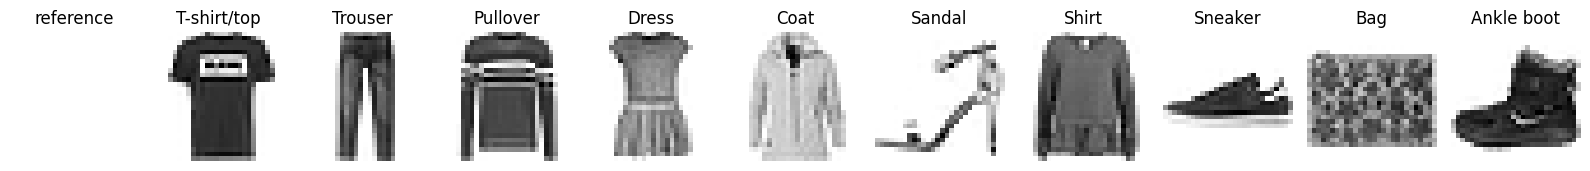

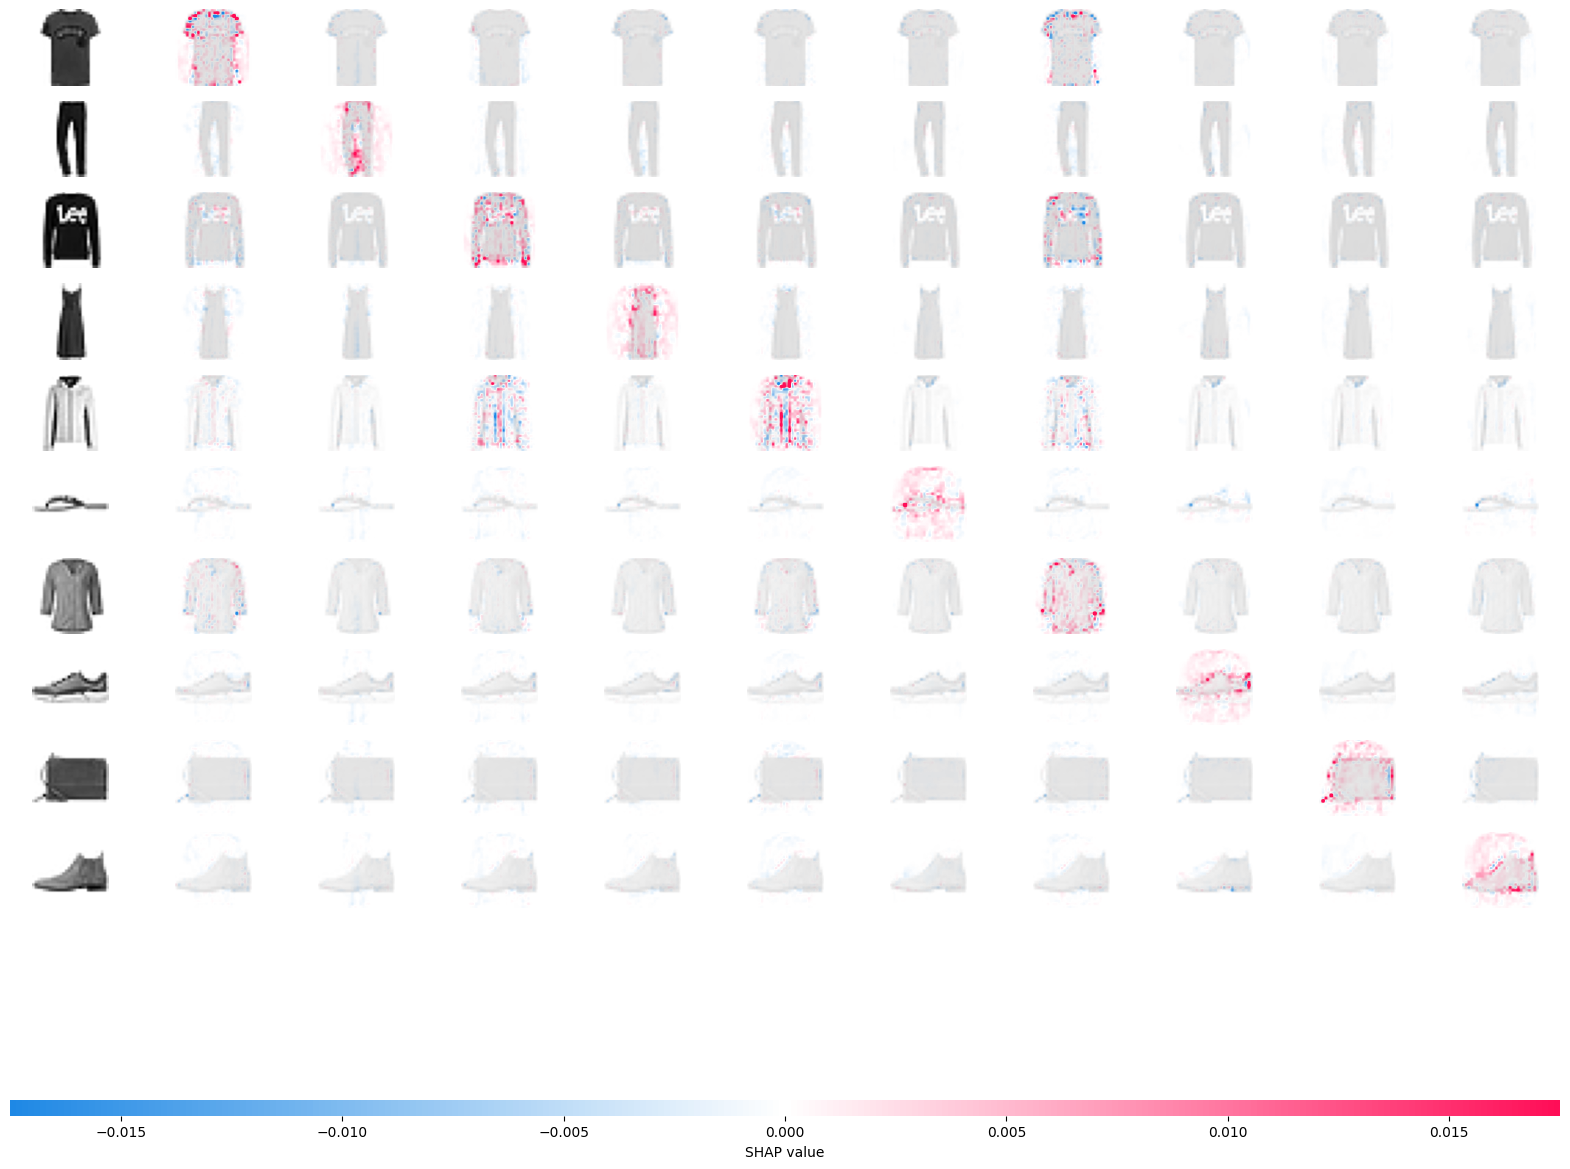

In [19]:
# Plot reference column
plot_categories(images_dict)
# Print an empty line to separate the two plots
print()
# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

Now, give yourself some time to comprehend what the story is trying to convey. It seems reasonable that the shapley values along the diagonal are the most common since the model can successfully categorise each of these 10 images. Particularly favourable values considering that the model (accurately) anticipated that class.

What else is there to infer from this story? Focus on only one instance. Consider the sixth class, the coat, as an example. It appears that the model had additional "reasons" for classifying it as a pullover or shirt. This can be inferred from the fact that certain clases have positive shap values.

To make sure that this was the case, let's look at the tensor of predictions:

In [21]:
# Save the probability of belonging to each class for the fifth element of the set
coat_probs = predictions[4]
# Order the probabilities in ascending order
coat_args = np.argsort(coat_probs)
# Reverse the list and get the top 3 probabilities
top_coat_args = coat_args[::-1][:3]
# Print (ordered) top 3 classes
for i in list(top_coat_args):
    print(class_names[i])

Coat
Pullover
Shirt


In actuality, the model determined that these 3 classes were the most likely candidates for the coat image. Given how similar these objects are to one another, this makes sense.

Take a peek at the first-class t-shirt right now. The pullover and this item are extremely similar, although this one lacks long sleeves. It is expected that white pixels in the vicinity of the long sleeves will have high shap values when categorised as a t-shirt. Additionally, as the model would anticipate that these pixels would be coloured if the item were in fact a pullover, white pixels in this location will result in negative shap values for classification as a pullover.

You can get a lot of insight repeating this process for all the classes.

Explainable classifier using XGBoost :  Various plots available in SHAP

Generate the XGB Classifier:

In [22]:
import pandas as pd
import shap

In [23]:
# import the dataset from Sklearn
from sklearn.datasets import load_breast_cancer
# Read the DataFrame, first using the feature data
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
# Add a target column, and fill it with the target data
df['target'] = data.target
# Show the first five rows
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [24]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [25]:
y = df['target'].to_frame() # define Y
X = df[df.columns.difference(['target'])] # define X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # create train and test
# build model - Xgboost
xgb_mod = XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train,y_train.values.ravel())
# make prediction and check model accuracy
y_pred = xgb_mod.predict(X_test)
# Performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.61%


[03:35:28] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
[03:35:28] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.


CAPSTONE PROJECT: Explainable ADABoost Classifier



The data provided below are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

The dataset had around 13 Features and a 14th column indicating the class of the wine is also included in the set.. Design a classification model with 3 different classifiers namely KNN, SVC and AdaBosst Classifier from the dataset “wine_dataset.csv ” [the original dataset is taken from UCI repository]

Dataset has 13 features & 178 samples. Try to Explain the and compare which features were considered most important by every model using the SHAP library and also comment on their explanation accuracy of the same.